In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Set dataset paths
trainA_path = "/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA"  # Poor-quality images
trainB_path = "/content/drive/MyDrive/Cycle-GAN/Unpaired/trainB"  # High-quality images

In [ ]:
import tensorflow as tf
import os

trainA_path = "/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA"  # Poor-quality images
trainB_path = "/content/drive/MyDrive/Cycle-GAN/Unpaired/trainB"  # High-quality images
# Function to check image size
def check_image_size(image_path, target_size=(256, 256)):
    try:
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)

        # Check if the image size matches the target size
        if image.shape[0] != target_size[0] or image.shape[1] != target_size[1]:
            return image_path
        return None
    except Exception as e:
        print(f"Error checking image {image_path}: {e}")
        return image_path

# Function to check all images in a folder
def check_folder_images(folder_path, target_size=(256, 256)):
    incorrect_size_images = []
    image_files = os.listdir(folder_path)

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        result = check_image_size(image_path, target_size)
        if result:
            incorrect_size_images.append(result)

    return incorrect_size_images

# Check images in trainA and trainB folders
incorrect_size_A = check_folder_images(trainA_path)
incorrect_size_B = check_folder_images(trainB_path)

# Print results
print("Images in trainA with incorrect size:")
for image_path in incorrect_size_A:
    print(image_path)

print("\nImages in trainB with incorrect size:")
for image_path in incorrect_size_B:
    print(image_path)

Images in trainA with incorrect size:
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_856up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_636up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_625up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_738up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_742up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_584up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_508up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_492up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_896up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_592up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_717up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_840up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_960up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_919up.jpg
/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA/nm_600up.jpg
/content/drive/MyDrive/Cycle-GAN

**Load and Preprocess Images**

In [ ]:
import tensorflow as tf
import os

# Function to load and preprocess images
def load_image(image_path, size=(256, 256)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, size)
    image = tf.cast(image, tf.float32) / 127.5 - 1
    return image

# Load unpaired dataset
def load_unpaired_dataset(trainA_path, trainB_path, batch_size=2):
    trainA_images = [os.path.join(trainA_path, fname) for fname in os.listdir(trainA_path)]
    trainB_images = [os.path.join(trainB_path, fname) for fname in os.listdir(trainB_path)]

    # Create TensorFlow datasets
    datasetA = tf.data.Dataset.from_tensor_slices(trainA_images)
    datasetA = datasetA.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    datasetA = datasetA.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    datasetB = tf.data.Dataset.from_tensor_slices(trainB_images)
    datasetB = datasetB.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    datasetB = datasetB.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return datasetA, datasetB

# Set paths
trainA_path = "/content/drive/MyDrive/Cycle-GAN/Unpaired/trainA"
trainB_path = "/content/drive/MyDrive/Cycle-GAN/Unpaired/trainB"

# Load the dataset
datasetA, datasetB = load_unpaired_dataset(trainA_path, trainB_path, batch_size=2)


Number of images in Domain A: 250
Number of images in Domain B: 250


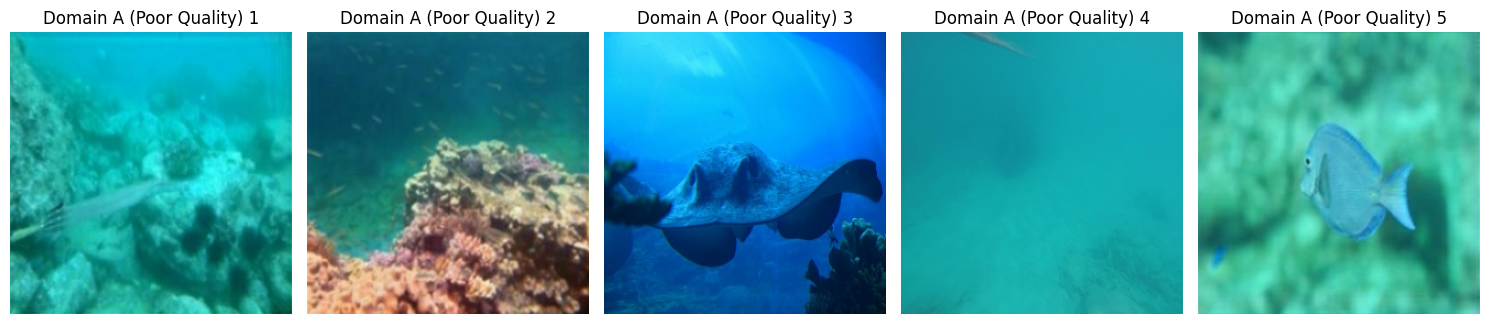

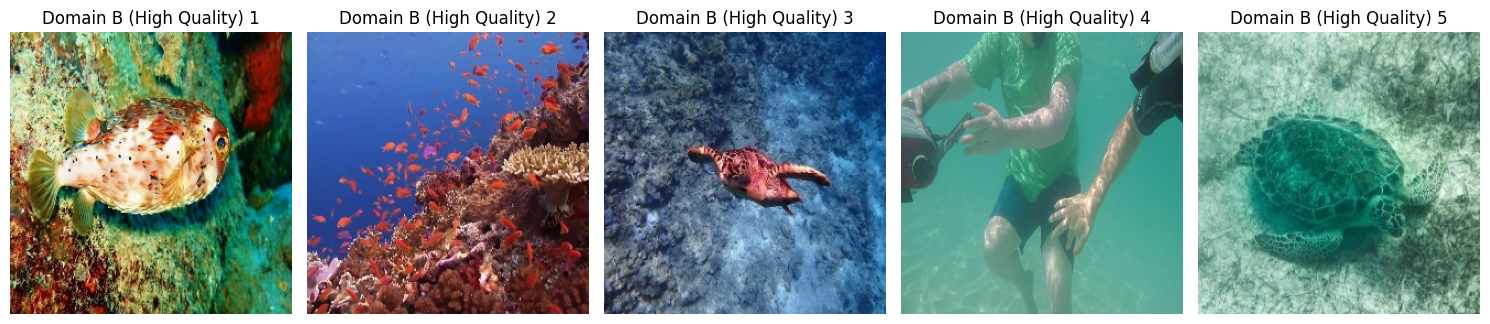

In [ ]:
# Check the number of images in each dataset
print(f"Number of images in Domain A: {len(list(datasetA))}")
print(f"Number of images in Domain B: {len(list(datasetB))}")

# Function to plot random images
def plot_images(dataset, title, num_images=5):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0] * 0.5 + 0.5)
        plt.title(f"{title} {i + 1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Plot images from Domain A
plot_images(datasetA, "Domain A (Poor Quality)")

# Plot images from Domain B
plot_images(datasetB, "Domain B (High Quality)")


**ResNet-based generator**

In [ ]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling
    x = tf.keras.layers.Conv2D(64, 7, strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Residual blocks
    for _ in range(6):
        y = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(x)
        y = tf.keras.layers.BatchNormalization()(y)
        y = tf.keras.layers.ReLU()(y)
        y = tf.keras.layers.Conv2D(256, 3, strides=1, padding='same')(y)
        y = tf.keras.layers.BatchNormalization()(y)
        x = tf.keras.layers.Add()([x, y])

    # Upsampling
    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Output layer
    outputs = tf.keras.layers.Conv2D(3, 7, strides=1, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Build the generator model
generator = build_generator()

# Print model summary
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ re_lu_2[0][0],         │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 7,852,547 (29.96 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 7,424 (29.00 KB)

**PatchGAN Based Discriminator**

In [ ]:
def build_discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    #First Convolutional Layer
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    #Downsampling
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    #Final Convolutional Layers
    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    outputs = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Build the discriminator model
discriminator = build_discriminator()

# Print model summary
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
# Adversarial loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Cycle consistency loss
def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

# Identity loss
def identity_loss(real_image, same_image, lambda_identity=0.5):
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))

In [ ]:
# Enable eager execution
tf.config.run_functions_eagerly(True)

# Build models
G_A2B = build_generator()
G_B2A = build_generator()
D_A = build_discriminator()
D_B = build_discriminator()

# Optimizers - Create separate optimizers for each discriminator
G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_A_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Optimizer for D_A
D_B_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  # Optimizer for D_B

# Training loop
@tf.function
def train_step(real_A, real_B):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        fake_B = G_A2B(real_A, training=True)
        cycled_A = G_B2A(fake_B, training=True)

        fake_A = G_B2A(real_B, training=True)
        cycled_B = G_A2B(fake_A, training=True)

        # Discriminator outputs
        real_output_A = D_A(real_A, training=True)
        fake_output_A = D_A(fake_A, training=True)

        real_output_B = D_B(real_B, training=True)
        fake_output_B = D_B(fake_B, training=True)

        # Losses
        G_A2B_loss = generator_loss(fake_output_B)
        G_B2A_loss = generator_loss(fake_output_A)

        cycle_loss_A = cycle_consistency_loss(real_A, cycled_A)
        cycle_loss_B = cycle_consistency_loss(real_B, cycled_B)

        total_G_loss = G_A2B_loss + G_B2A_loss + cycle_loss_A + cycle_loss_B

        D_A_loss = discriminator_loss(real_output_A, fake_output_A)
        D_B_loss = discriminator_loss(real_output_B, fake_output_B)

# Apply gradients - Use the correct optimizer for each discriminator
    G_gradients = tape.gradient(total_G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    D_A_gradients = tape.gradient(D_A_loss, D_A.trainable_variables)
    D_B_gradients = tape.gradient(D_B_loss, D_B.trainable_variables)

    G_optimizer.apply_gradients(zip(G_gradients, G_A2B.trainable_variables + G_B2A.trainable_variables))
    D_A_optimizer.apply_gradients(zip(D_A_gradients, D_A.trainable_variables)) # Apply to D_A
    D_B_optimizer.apply_gradients(zip(D_B_gradients, D_B.trainable_variables)) # Apply to D_B

    return total_G_loss, D_A_loss, D_B_loss

In [ ]:
from tqdm import tqdm
# Define save path for models
MODEL_SAVE_PATH = "/content/drive/MyDrive/Cycle-GAN"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Function to save the final trained models
def save_final_models():
    G_A2B.save(os.path.join(MODEL_SAVE_PATH, "G_A2B_Final.h5"))
    G_B2A.save(os.path.join(MODEL_SAVE_PATH, "G_B2A_Final.h5"))
    print("Final trained models saved successfully!")

# Training loop
EPOCHS = 20
for epoch in range(EPOCHS):
    progress_bar = tqdm(zip(datasetA, datasetB), total=len(datasetA), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    for real_A, real_B in progress_bar:
        G_loss, D_A_loss, D_B_loss = train_step(real_A, real_B)
        progress_bar.set_postfix(G_loss=G_loss.numpy(), D_A_loss=D_A_loss.numpy(), D_B_loss=D_B_loss.numpy())

    print(f"Epoch {epoch + 1}/{EPOCHS} completed")

save_final_models()

Epoch 1/20: 100%|██████████| 250/250 [09:34<00:00,  2.30s/it, D_A_loss=0.842, D_B_loss=1.17, G_loss=6.93]


Epoch 1/20 completed


Epoch 2/20: 100%|██████████| 250/250 [09:28<00:00,  2.27s/it, D_A_loss=0.916, D_B_loss=1.1, G_loss=7.13]


Epoch 2/20 completed


Epoch 3/20: 100%|██████████| 250/250 [09:25<00:00,  2.26s/it, D_A_loss=1.24, D_B_loss=0.425, G_loss=8.58]


Epoch 3/20 completed


Epoch 4/20: 100%|██████████| 250/250 [09:22<00:00,  2.25s/it, D_A_loss=1.23, D_B_loss=1.44, G_loss=5.18]


Epoch 4/20 completed


Epoch 5/20: 100%|██████████| 250/250 [09:23<00:00,  2.26s/it, D_A_loss=1.35, D_B_loss=0.466, G_loss=7.36]


Epoch 5/20 completed


Epoch 6/20: 100%|██████████| 250/250 [09:21<00:00,  2.25s/it, D_A_loss=1.44, D_B_loss=1.33, G_loss=5.7]


Epoch 6/20 completed


Epoch 7/20: 100%|██████████| 250/250 [09:22<00:00,  2.25s/it, D_A_loss=0.824, D_B_loss=0.62, G_loss=6.7]


Epoch 7/20 completed


Epoch 8/20: 100%|██████████| 250/250 [09:19<00:00,  2.24s/it, D_A_loss=1.44, D_B_loss=1.2, G_loss=7.26]


Epoch 8/20 completed


Epoch 9/20: 100%|██████████| 250/250 [09:19<00:00,  2.24s/it, D_A_loss=1.11, D_B_loss=0.813, G_loss=7.5]


Epoch 9/20 completed


Epoch 10/20: 100%|██████████| 250/250 [09:22<00:00,  2.25s/it, D_A_loss=1.09, D_B_loss=0.753, G_loss=6.35]


Epoch 10/20 completed


Epoch 11/20: 100%|██████████| 250/250 [09:21<00:00,  2.24s/it, D_A_loss=1.5, D_B_loss=0.423, G_loss=7.38]


Epoch 11/20 completed


Epoch 12/20: 100%|██████████| 250/250 [09:21<00:00,  2.25s/it, D_A_loss=1.28, D_B_loss=0.402, G_loss=7.2]


Epoch 12/20 completed


Epoch 13/20: 100%|██████████| 250/250 [09:22<00:00,  2.25s/it, D_A_loss=1.86, D_B_loss=0.671, G_loss=6.62]


Epoch 13/20 completed


Epoch 14/20: 100%|██████████| 250/250 [09:21<00:00,  2.25s/it, D_A_loss=1.55, D_B_loss=1.07, G_loss=7.48]


Epoch 14/20 completed


Epoch 15/20: 100%|██████████| 250/250 [09:20<00:00,  2.24s/it, D_A_loss=2.57, D_B_loss=1.41, G_loss=6.97]


Epoch 15/20 completed


Epoch 16/20: 100%|██████████| 250/250 [09:18<00:00,  2.23s/it, D_A_loss=1.42, D_B_loss=0.913, G_loss=8.46]


Epoch 16/20 completed


Epoch 17/20: 100%|██████████| 250/250 [09:21<00:00,  2.24s/it, D_A_loss=0.834, D_B_loss=1.99, G_loss=7.12]


Epoch 17/20 completed


Epoch 18/20: 100%|██████████| 250/250 [09:19<00:00,  2.24s/it, D_A_loss=1.59, D_B_loss=0.719, G_loss=8.88]


Epoch 18/20 completed


Epoch 19/20: 100%|██████████| 250/250 [09:15<00:00,  2.22s/it, D_A_loss=0.68, D_B_loss=1.13, G_loss=6.35]


Epoch 19/20 completed


Epoch 20/20: 100%|██████████| 250/250 [09:17<00:00,  2.23s/it, D_A_loss=1.11, D_B_loss=0.446, G_loss=6.75]


Epoch 20/20 completed


Final trained models saved successfully!


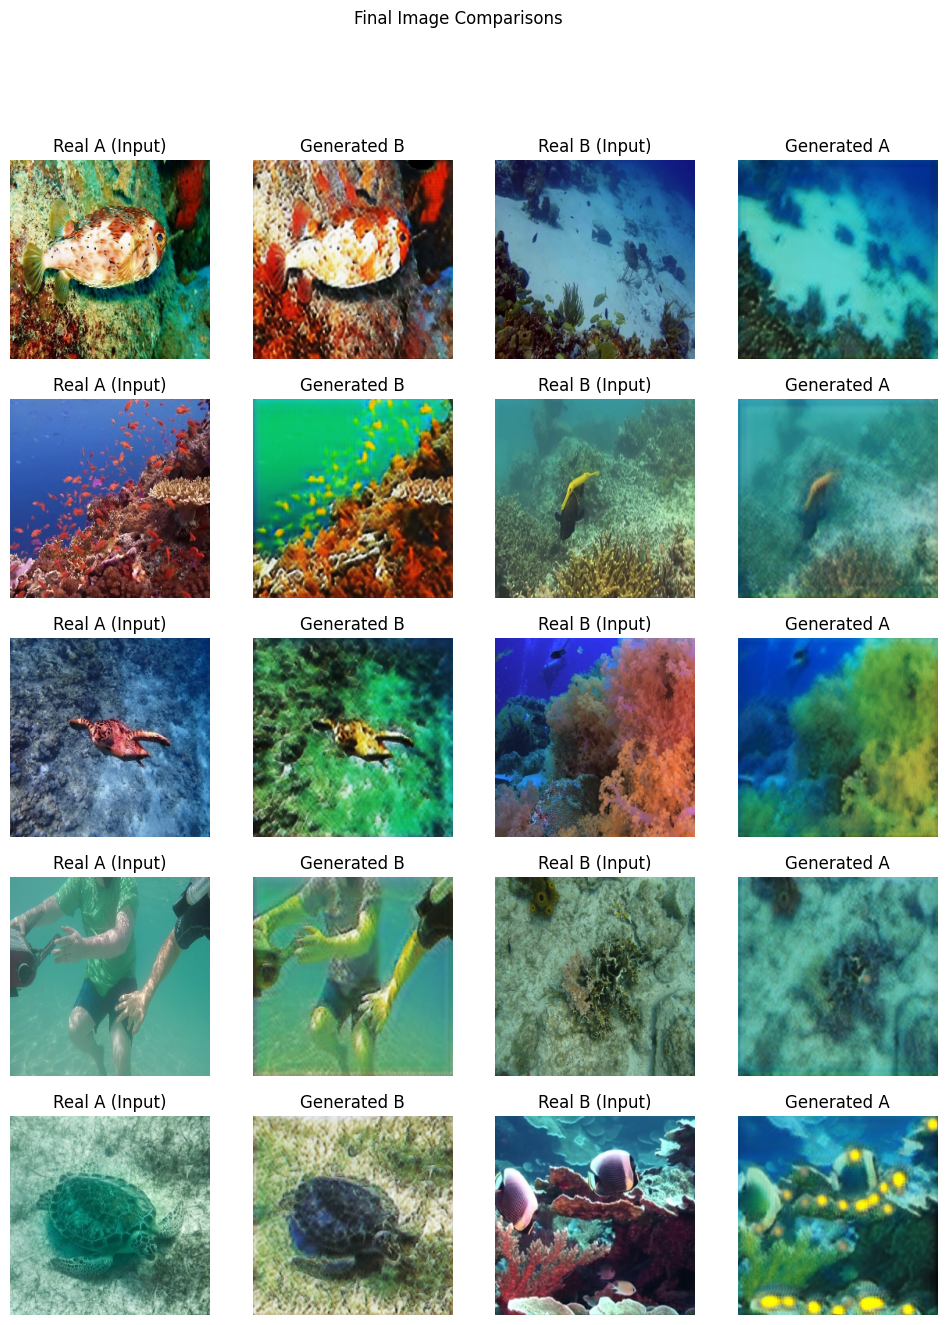

In [ ]:
# Function to visualize multiple results
def visualize_results(test_A, test_B, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(12, num_samples * 3))

    for i in range(num_samples):
        real_A = test_A[i]
        real_B = test_B[i]

        fake_B = G_A2B(tf.expand_dims(real_A, axis=0), training=False)[0]  # Generate fake B
        fake_A = G_B2A(tf.expand_dims(real_B, axis=0), training=False)[0]  # Generate fake A

        real_A = (real_A.numpy() + 1) / 2  # Normalize
        fake_B = (fake_B.numpy() + 1) / 2
        real_B = (real_B.numpy() + 1) / 2
        fake_A = (fake_A.numpy() + 1) / 2

        axes[i, 0].imshow(real_A)
        axes[i, 0].set_title("Real A (Input)")
        axes[i, 1].imshow(fake_B)
        axes[i, 1].set_title("Generated B")
        axes[i, 2].imshow(real_B)
        axes[i, 2].set_title("Real B (Input)")
        axes[i, 3].imshow(fake_A)
        axes[i, 3].set_title("Generated A")

        for j in range(4):
            axes[i, j].axis("off")

    plt.suptitle("Final Image Comparisons")
    plt.show()

# Select some test images for visualization
test_samples = 5  # Number of images to visualize
test_A = []
test_B = []

# Extract 'test_samples' images from the dataset
for real_A, real_B in datasetA.take(test_samples).zip(datasetB.take(test_samples)):
    test_A.append(real_A)
    test_B.append(real_B)

# Convert list to NumPy arrays for easier processing
test_A = tf.stack(test_A)
test_B = tf.stack(test_B)

# Call visualization function separately after training
visualize_results(test_A, test_B, num_samples=test_samples)